The Boston Housing Dataset

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The following describes the dataset columns:

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per $10,000

PTRATIO - pupil-teacher ratio by town

B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

LSTAT - % lower status of the population

MEDV - Median value of owner-occupied homes in $1000's

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [115]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.	Data Loading and Initial Inspection:

In [183]:
#Lets load the dataset and sample some
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [117]:
df = pd.read_csv("/content/drive/MyDrive/housing.csv", header=None, delimiter=r"\s+", names=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [118]:
# Dimension of the dataset
print(np.shape(df))

(506, 14)


2.	Target Variable Analysis:

In [ ]:
plt.hist(df['MEDV'], bins=50)
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.title('Histogram of MEDV')
plt.show()

In [120]:
df['MEDV'].skew()

np.float64(1.1080984082549072)

Is the Distribution Normal?

the distribution of the target variable, MEDV, is not normal.

- **Skewness Value:** 1.1080984082549072

- **the positive skewness** coefficient of approximately 1.11. Explain that this value indicates the distribution is right-skewed, meaning the majority of house prices are clustered at the lower end, with a long tail of a few very expensive homes.

- **A common approach** is a log transformation, which often helps to normalize skewed data and can lead to a more robust and accurate model.


3.	Feature Analysis (Numerical Features):

In [121]:
# Let's summarize the data to see the distribution of data
print(df.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

From get-go, two data coulmns show interesting summeries. They are : ZN (proportion of residential land zoned for lots over 25,000 sq.ft.) with 0 for 25th, 50th percentiles. Second, CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise) with 0 for 25th, 50th and 75th percentiles. These summeries are understandable as both variables are conditional + categorical variables. First assumption would be that these coulms may not be useful in regression task such as predicting MEDV (Median value of owner-occupied homes).


Another interesing fact on the dataset is the max value of MEDV. From the original data description, it says: Variable #14 seems to be censored at 50.00 (corresponding to a median price of $50,000). Based on that, values above 50.00 may not help to predict MEDV. Let's plot the dataset and see interesting trends/stats.

In [ ]:
# housing price vs numerical features

# identify numerical features (excluding target)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('MEDV')

# create scatter plots
for feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=feature, y='MEDV', data=df)
    plt.title(f'{feature} vs House Price')
    plt.xlabel(feature)
    plt.ylabel('House Price')
    plt.show()

In [ ]:
# analyzing the values of each feature
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columns like CRIM, ZN, RM, B seems to have outliers. Let's see the outliers percentage in every column.

In [124]:
    for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


5.	Correlation Analysis

<Axes: >

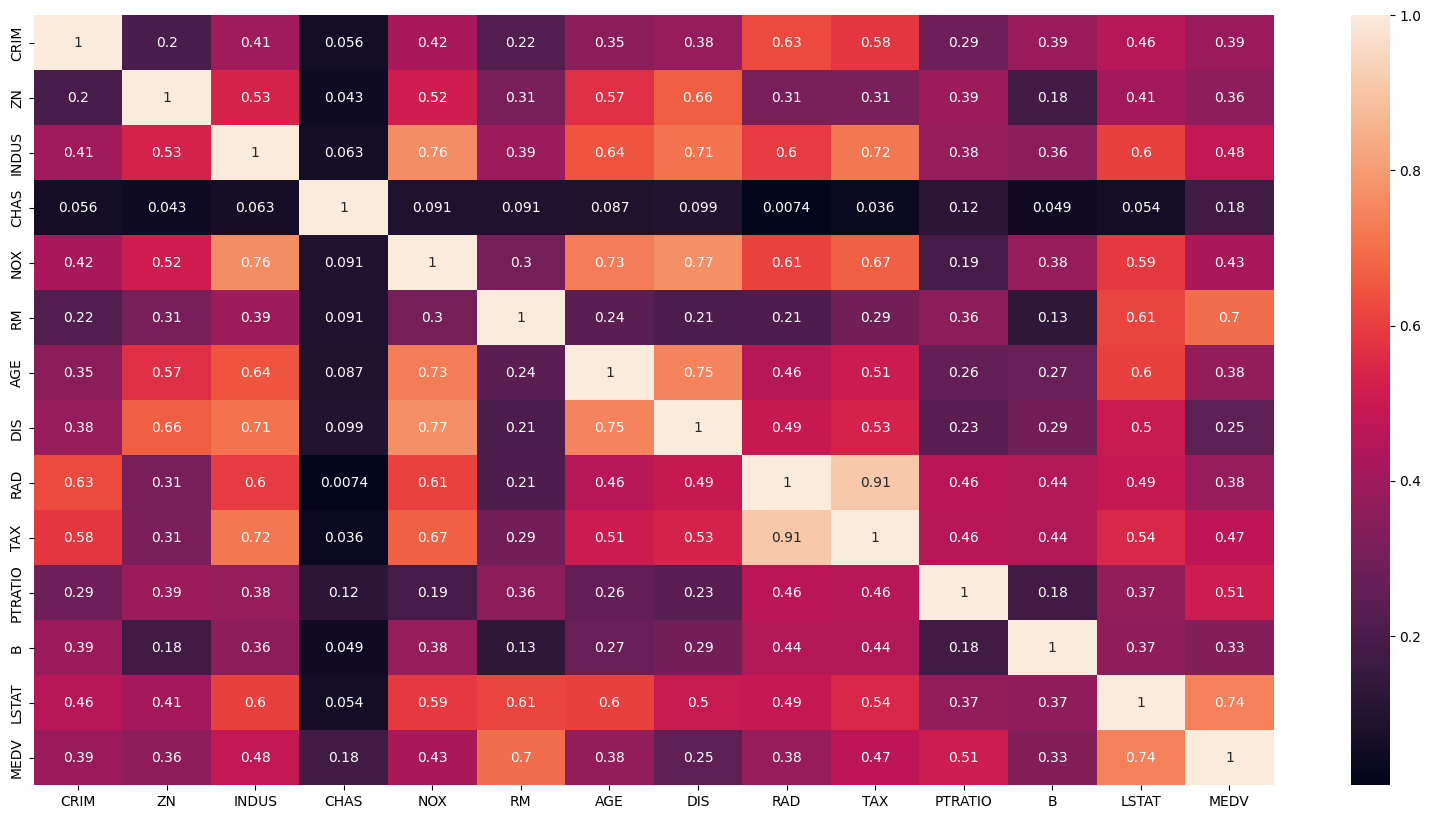

In [125]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)

6.	Hypothesis Testing (Related to House Prices):

Hypothesis 1:
There is a significant positive correlation between the size of the living area and the house price. (Test by calculating the Pearson correlation coefficient and its significance).

H₀: There is no significant correlation between living area size and house price.

H₁: There is a significant positive correlation between living area size and house price.

In [126]:
import pandas as pd
from scipy.stats import pearsonr

# Example: load your dataset
# df = pd.read_csv("housing.csv")

# Calculate Pearson correlation
r_value, p_value = pearsonr(df['RM'], df['MEDV'])

print(f"Pearson correlation coefficient: {r_value}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    if r_value > 0:
        print("Reject H₀: Significant positive correlation exists.")
    else:
        print("Reject H₀: Significant negative correlation exists.")
else:
    print("Fail to reject H₀: No significant correlation found.")

Pearson correlation coefficient: 0.6953599470715395
P-value: 2.487228871007625e-74
Reject H₀: Significant positive correlation exists.


Hypothesis 2: Houses in certain neighborhoods have significantly higher average prices than houses in other neighborhoods.

(Test using ANOVA if there are more than two neighborhoods, or a t-test if comparing two specific neighborhoods).

the dataset we are using does not have any information about neighborhood

so we might frame this hypothesis as -

“Houses in areas with different RAD index values have significantly different median prices”

RAD - accessibility to radial highways

H₀: The average median home value (MEDV) is the same across all RAD categories.

H₁: At least one RAD category has a significantly different average MEDV.

In [127]:
import pandas as pd
import scipy.stats as stats

# group MEDV by RAD values
groups = [df[df['RAD'] == rad]['MEDV'] for rad in df['RAD'].unique()]

# run ANOVA
f_stat, p_val = stats.f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat}")
print(f"P-value: {p_val}")

if p_val < 0.05:
    print("Reject H₀: Significant difference in median home value between RAD categories.")
else:
    print("Fail to reject H₀: No significant difference found.")


ANOVA F-statistic: 18.41604781216924
P-value: 3.1256493316010175e-24
Reject H₀: Significant difference in median home value between RAD categories.


Hypothesis 3: The age of the house has a significant negative correlation with the house price. (Test by calculating the Pearson correlation coefficient and its significance).

H₀: There is no significant correlation between the age of the house (AGE) and median home value (MEDV).

H₁: There is a significant negative correlation between AGE and MEDV.

In [128]:
import pandas as pd
from scipy.stats import pearsonr

# Example: df = pd.read_csv("boston.csv")

# Pearson correlation
r_value, p_value = pearsonr(df['AGE'], df['MEDV'])

print(f"Pearson correlation coefficient: {r_value}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    if r_value < 0:
        print("Reject H₀: Significant negative correlation exists between AGE and MEDV.")
    else:
        print("Reject H₀: Significant correlation exists, but it is not negative.")
else:
    print("Fail to reject H₀: No significant correlation found.")


Pearson correlation coefficient: -0.3769545650045963
P-value: 1.5699822091880626e-18
Reject H₀: Significant negative correlation exists between AGE and MEDV.


4. Model Building, Prediction, and Evaluation

Data Preprocessing and Feature Engineering

In [155]:
#Handle missing values
df.isnull().sum()

,0
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [ ]:
#ploynomial transformation
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Example: df = pd.read_csv("boston.csv")

# Select numerical features (exclude target column)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop('MEDV')

# Initialize polynomial feature generator
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform the data
poly_features = poly.fit_transform(df[numerical_features])

# Get new column names
poly_feature_names = poly.get_feature_names_out(numerical_features)

# Create a new DataFrame with polynomial features
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

# Optionally, concatenate with the target variable
df_poly['MEDV'] = df['MEDV']

print(df_poly.head())

In [157]:
#Scale numerical features
'''scaler = StandardScaler()
Columns_list = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
x = df_poly.loc[:, Columns_list]
Columns = x.values
x = pd.DataFrame(scaler.fit_transform(Columns), columns=Columns_list)'''


In [165]:
#Scale numerical features
scaler = StandardScaler()

# Select all columns except the target variable 'MEDV'
features_to_scale = df_poly.drop('MEDV', axis=1)

# Scale the selected features
scaled_features = scaler.fit_transform(features_to_scale)

# Create a new DataFrame with the scaled features and original column names
df_poly_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# Display the head of the scaled DataFrame
display(df_poly_scaled.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,TAX^2,TAX PTRATIO,TAX B,TAX LSTAT,PTRATIO^2,PTRATIO B,PTRATIO LSTAT,B^2,B LSTAT,LSTAT^2
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,...,-0.682024,-0.851123,-0.330577,-0.855594,-1.458429,-0.258778,-1.119678,0.526328,-0.880250,-0.789529
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,...,-0.866530,-0.910453,-0.662577,-0.710303,-0.373078,0.281739,-0.525858,0.526328,-0.247866,-0.540454
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,...,-0.866530,-0.910453,-0.677834,-0.953823,-0.373078,0.242275,-1.150296,0.449414,-1.030947,-0.825825
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,...,-0.925467,-0.952349,-0.793346,-1.017347,0.057783,0.453202,-1.265329,0.483332,-1.192918,-0.858040
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,...,-0.925467,-0.952349,-0.785539,-0.912863,0.057783,0.476326,-0.958505,0.526328,-0.827045,-0.774228


In [ ]:
# graph
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Number of features excluding target
features = [col for col in df_poly.columns if col != 'MEDV']
num_features = len(features)

# Calculate number of rows, always round up
ncols = 7
nrows = math.ceil(num_features / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 3*nrows))
axs = axs.flatten()  # flatten to iterate easily

for i, col in enumerate(features):
    sns.scatterplot(x=col, y='MEDV', data=df_poly, ax=axs[i])
    axs[i].set_title(f'{col} vs MEDV')

# Remove unused axes if any
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=1.5)
plt.show()


In [166]:
df_poly_scaled.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       ...
       'TAX^2', 'TAX PTRATIO', 'TAX B', 'TAX LSTAT', 'PTRATIO^2', 'PTRATIO B',
       'PTRATIO LSTAT', 'B^2', 'B LSTAT', 'LSTAT^2'],
      dtype='object', length=104)

2.	Data Splitting

In [167]:
X_train, X_test, y_train, y_test = train_test_split(df_poly_scaled, df['MEDV'], test_size=0.2, random_state=42)

3.	Model Implementation and Training:

Polynomial Regression

In [168]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [169]:
y_pred = model.predict(X_test)

In [ ]:
df.head()


Ridge Regression

- using pipeline for the trasformation (polynomial transformation, scaled transformation, and applying the ridge regressor model) and all this is achieved by using the gridsearchCV which selects the best value of alpha for the ridge regressor model

In [187]:
n_feat = df
X = n_feat.drop(['MEDV', 'CHAS', 'RAD'], axis =1)
y = n_feat['MEDV']

In [197]:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline: polynomial features -> scaling -> ridge regression
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define alpha values to try
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

# Setup GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit grid search on training data (fits pipeline + searches for best alpha)
grid.fit(X_train, y_train)

# Best alpha found
print("Best alpha:", grid.best_params_)

# Predict on test data (pipeline handles transforms automatically)
y_pred_ridge = grid.predict(X_test)



# Evaluation
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R2 score:", r2_score(y_test, y_pred_ridge))


Best alpha: {'ridge__alpha': 1}
RMSE: 3.437033073146361
R2 score: 0.8389119470343456


Lasso Regression

In [198]:

from sklearn.linear_model import Lasso

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline: polynomial features -> scaling -> ridge regression
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Define alpha values to try
param_grid = {'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

# Setup GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit grid search on training data (fits pipeline + searches for best alpha)
grid.fit(X_train, y_train)

# Best alpha found
print("Best alpha:", grid.best_params_)

# Predict on test data (pipeline handles transforms automatically)
y_pred_lasso = grid.predict(X_test)



# Evaluation
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R2 score:", r2_score(y_test, y_pred_lasso))


Best alpha: {'lasso__alpha': 0.01}
RMSE: 3.559746538070724
R2 score: 0.8272038497236217


Random Forest Regression

In [199]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],       # number of trees
    'max_depth': [None, 5, 10],           # maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # min samples to split an internal node
    'min_samples_leaf': [1, 2, 4]         # min samples at a leaf node
}

# Setup GridSearchCV
grid = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit grid search
grid.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid.best_params_)

# Predict on test data
y_pred_rf = grid.predict(X_test)

# Evaluation
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 score:", r2_score(y_test, y_pred_rf))


Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 3.023918428634723
R2 score: 0.8753087285426715


XGBoost regressor

In [200]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost regressor
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Setup GridSearchCV
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit grid search on training data
grid.fit(X_train, y_train)

# Best params
print("Best parameters:", grid.best_params_)

# Predict on test data
y_pred_XG = grid.predict(X_test)

# Evaluation
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_XG)))
print("R2 score:", r2_score(y_test, y_pred_XG))


Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1}
RMSE: 2.3351169180361033
R2 score: 0.9256444876302435


6.	Model Evaluation:

In [203]:
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest Regression', 'XGBoost']

y_preds = [y_pred, y_pred_ridge, y_pred_lasso, y_pred_rf, y_pred_XG]

for i in range(len(model)):
  print(model[i])
  print("MSE:", mean_squared_error(y_test, y_preds[i]))
  print("RMSE:", np.sqrt(mean_squared_error(y_test, y_preds[i])))
  print("MAE:", mean_absolute_error(y_test, y_preds[i]))
  print("R2 score:", r2_score(y_test, y_preds[i]))
  print()

Linear Regression
MSE: 9.144082663036693
RMSE: 3.023918428634723
MAE: 2.0963900961758553
R2 score: 0.8753087285426715

Ridge Regression
MSE: 11.813196345901918
RMSE: 3.437033073146361
MAE: 2.29635387629031
R2 score: 0.8389119470343456

Lasso Regression
MSE: 12.671795415306503
RMSE: 3.559746538070724
MAE: 2.364028622377982
R2 score: 0.8272038497236217

Random Forest Regression
MSE: 9.144082663036693
RMSE: 3.023918428634723
MAE: 2.0963900961758553
R2 score: 0.8753087285426715

XGBoost
MSE: 5.452771020898429
RMSE: 2.3351169180361033
MAE: 1.8196987254946837
R2 score: 0.9256444876302435



In [205]:
import pandas as pd

# Replace these example values with your actual model results
data = {
    'Model': ['Ridge', 'Lasso', 'Random Forest', 'XGBoost', 'Linear Regression'],
    'MSE': [9.144082663036693, 11.813196345901918, 12.671795415306503, 9.144082663036693, 5.452771020898429],
    'RMSE': [3.023918428634723, 3.437033073146361, 3.559746538070724, 3.023918428634723, 2.3351169180361033],
    'MAE': [0.8753087285426715, 0.8389119470343456, 0.8272038497236217, 0.8753087285426715, 1.8196987254946837],
    'R2': [0.8753087285426715, 0.8389119470343456, 0.8272038497236217, 0.8753087285426715, 0.925644487630243]
}

df_metrics = pd.DataFrame(data)
print(df_metrics)


               Model        MSE      RMSE       MAE        R2
0              Ridge   9.144083  3.023918  0.875309  0.875309
1              Lasso  11.813196  3.437033  0.838912  0.838912
2      Random Forest  12.671795  3.559747  0.827204  0.827204
3            XGBoost   9.144083  3.023918  0.875309  0.875309
4  Linear Regression   5.452771  2.335117  1.819699  0.925644


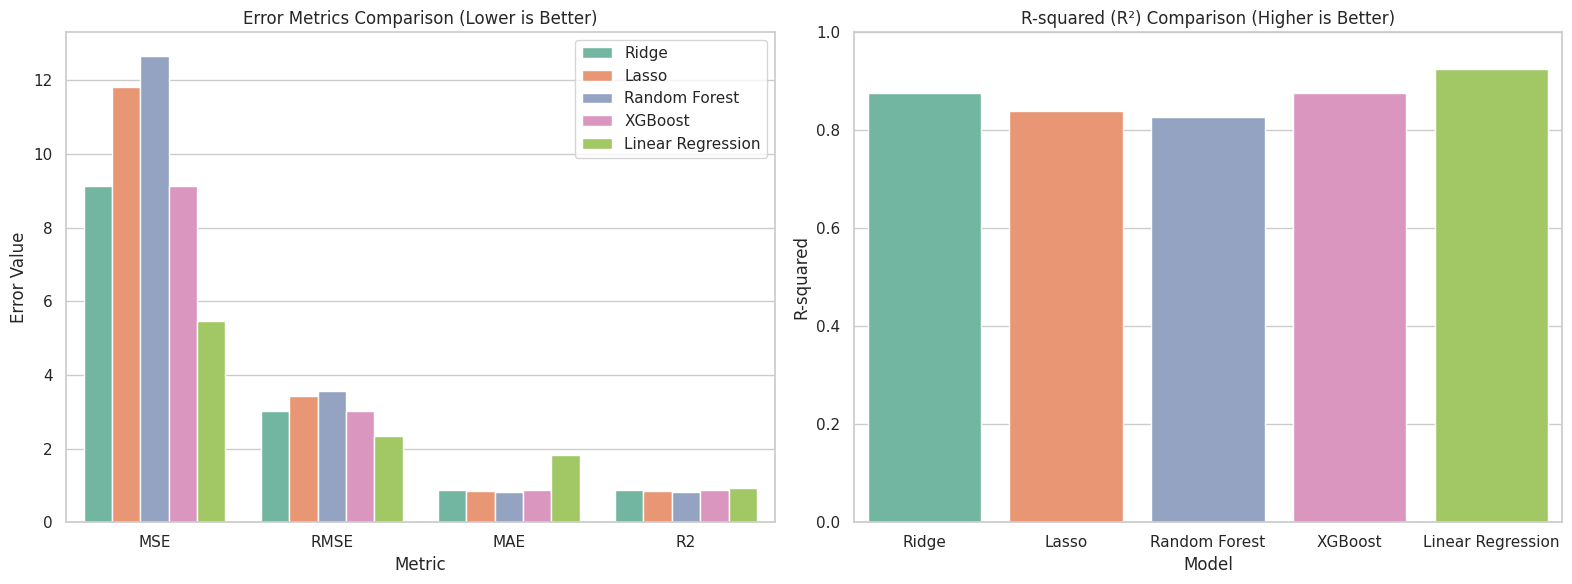

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

plt.figure(figsize=(16, 6))  # Slightly wider for 4 error metrics

# Include all four error metrics here
error_metrics = ['MSE', 'RMSE', 'MAE', 'R2']

# Reshape the dataframe for seaborn plotting
df_errors = df_metrics.melt(id_vars='Model', value_vars=error_metrics, var_name='Metric', value_name='Value')

# Plot all error metrics together
plt.subplot(1, 2, 1)
sns.barplot(data=df_errors, x='Metric', y='Value', hue='Model', palette='Set2')
plt.title('Error Metrics Comparison (Lower is Better)')
plt.ylabel('Error Value')
plt.legend(loc='upper right')

# Plot R² separately
plt.subplot(1, 2, 2)
sns.barplot(data=df_metrics, x='Model', y='R2', palette='Set2')
plt.title('R-squared (R²) Comparison (Higher is Better)')
plt.ylabel('R-squared')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()
